<h1>Importing Necessary Libraries</h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os , shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau

In [2]:
folder = 'brain_tumor_dataset/yes/'
count = 1

if os.path.exists(folder):
    print("Folder already exists")
else:
    for filename in os.listdir(folder):
        source = folder + filename
        Rename = folder + 'Y_' + str(count) + ".jpg"
        os.rename(source,Rename)
        count+=1
    print("All files are renamed")

Folder already exists


In [3]:
folder = 'brain_tumor_dataset/no/'
count = 1

if os.path.exists(folder):
    print("Folder already exists")
else:
    for filename in os.listdir(folder):
        source = folder + filename
        Rename = folder + 'NO_' + str(count) + ".jpg"
        os.rename(source,Rename)
        count+=1
    print("All files are renamed")

Folder already exists


# EDA (Exploratory Data Analysis)

In [5]:
yes_list = os.listdir('brain_tumor_dataset/yes/')
Yes_cases = len(yes_list)
print("Cases having tumor :",Yes_cases)

no_list = os.listdir('brain_tumor_dataset/no/')
No_cases = len(no_list)
print("Cases not having tumor :",No_cases)

Cases having tumor : 155
Cases not having tumor : 98


In [6]:
data = {"Having Tumor" : Yes_cases , "Not having tumor" : No_cases}

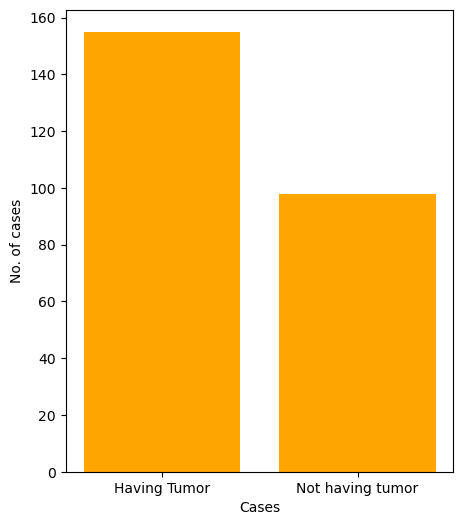

In [7]:
plt.figure(figsize=(5,6))
plt.bar(data.keys(),data.values(),color = 'orange')
plt.xlabel('Cases')
plt.ylabel('No. of cases')
plt.show()

# Data Augmentation

<h4>Since we have 155 (61%) cases having tumor and 98 (39%) cases not having tumor so the dataset is quite imbalances.</h4>
<h4>So we generate some extra images using Tensorflow and Keras.</h4>

In [11]:
def augmentation(file_dir, n_generated_samples,save_to_dir):
    New_img = ImageDataGenerator(rotation_range=40,       
                       width_shift_range=0.2,     
                       height_shift_range=0.2,    
                       shear_range=0.2,  
                       brightness_range=(0.3,0.1),
                       zoom_range=0.2,           
                       horizontal_flip=True,      
                       fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + "/" + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = "aug_" + filename[-4]
        i=0
        for batch in New_img.flow(x= image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = ".jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [77]:
yes_path = 'brain_tumor_dataset/yes/'
no_path = 'brain_tumor_dataset/no/'

augmented_data_path = 'Augmented_image/'

augmentation(file_dir=yes_path ,  n_generated_samples=6, save_to_dir=augmented_data_path+"yes")
augmentation(file_dir=no_path ,  n_generated_samples=9, save_to_dir=augmented_data_path+"no")

In [79]:
def img_summary(main_path):
    yes_path = 'Augmented_image/yes'
    no_path = 'Augmented_image/no'

    pos_cases = len(os.listdir(yes_path))
    neg_cases = len(os.listdir(no_path))
    
    total_cases = pos_cases + neg_cases
    
    p_per = (pos_cases*100)/total_cases
    n_per = (neg_cases*100)/total_cases

    print(f"Total no, of samples :{total_cases}")
    print(f"Positive case percentage :{p_per}")
    print(f"Negative case percentage :{n_per}")

In [81]:
img_summary(augmented_data_path)

Total no, of samples :1975
Positive case percentage :52.35443037974684
Negative case percentage :47.64556962025316


In [83]:
Yes_list = os.listdir('Augmented_image/yes')
yes_cases = len(Yes_list)
print("Cases having tumor :",yes_cases)

No_list = os.listdir('Augmented_image/no')
no_cases = len(No_list)
print("Cases not having tumor :",no_cases)

Cases having tumor : 1034
Cases not having tumor : 941


# Data Preprocessing

<h3>Cropping Image</h3>

In [86]:
import imutils

def crop_tumor(image,plot=False):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(5,5),0)

    thres = cv2.threshold(gray,45 ,255 ,cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts,key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight =  tuple(c[c[:,:,0].argmax()][0])
    extTop =  tuple(c[c[:,:,1].argmin()][0])
    extBot =  tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1],extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.tick_params(axis='both', which= 'both',top =False, bottom = False , left = False, right = False,
                        labelleft = False,labeltop = False,labelbottom = False,labelright = False)
        plt.title("Original Image")

        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which= 'both',top =False, bottom = False , left = False, right = False,
                        labelleft = False,labeltop = False,labelbottom = False,labelright = False)
        plt.title("Cropped Image")
        plt.show()
    return new_image

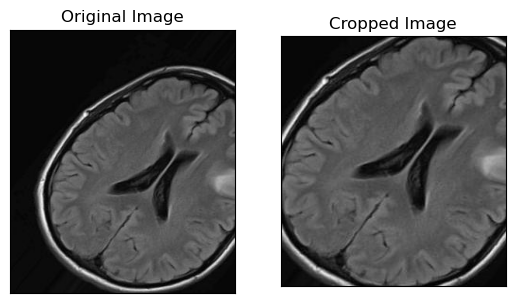

array([[[ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7],
        ...,
        [ 6,  6,  6],
        [ 9,  9,  9],
        [ 9,  9,  9]],

       [[ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7],
        ...,
        [ 5,  5,  5],
        [ 8,  8,  8],
        [ 8,  8,  8]],

       [[ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7],
        ...,
        [ 5,  5,  5],
        [ 8,  8,  8],
        [ 9,  9,  9]],

       ...,

       [[13, 13, 13],
        [12, 12, 12],
        [10, 10, 10],
        ...,
        [ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7]],

       [[11, 11, 11],
        [11, 11, 11],
        [ 9,  9,  9],
        ...,
        [ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7]],

       [[10, 10, 10],
        [ 9,  9,  9],
        [ 8,  8,  8],
        ...,
        [ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7]]], dtype=uint8)

In [88]:
img = cv2.imread(r"Augmented_image\yes\aug_._0_87..jpg")
crop_tumor(img,True)

In [90]:
folder1 = "Augmented_image/yes/"
folder2 = "Augmented_image/no/"

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img =crop_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img =crop_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [91]:
from sklearn.utils import shuffle

def load_data(dir_list,image_size):
    X= []
    y= []

    image_width,image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_tumor(image,plot = False)
            image = cv2.resize(image, dsize=(image_width,image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3] == 'yes':
                y.append(1)
            else:
                y.append(0)

    X= np.array(X)
    y= np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f" X shape is {X.shape}")
    return X,y

In [94]:
augmented_path = 'Augmented_image/'
augmented_yes = augmented_path + "yes"
augmented_no = augmented_path + "no"

IMAGE_WIDTH,IMAGE_HEIGHT = (240,240)

X,y = load_data([augmented_yes,augmented_no],(IMAGE_WIDTH,IMAGE_HEIGHT))

Number of example is : 1975
 X shape is (1975, 240, 240, 3)


# Data Splitting

In [97]:
base_dir = "Tumourous_and_Non_Tumourous"

if os.path.exists(base_dir):
    print("Folder already exists")
else:
    if not os.path.isdir("Tumourous_and_Non_Tumourous"):
        base_dir = "Tumourous_and_Non_Tumourous"
        os.makedirs(base_dir)

In [99]:
if not os.path.isdir("Tumourous_and_Non_Tumourous/train"):
    train_dir = os.path.join(base_dir , "train")
    os.makedirs(train_dir)    
if not os.path.isdir("Tumourous_and_Non_Tumourous/test"):
    test_dir = os.path.join(base_dir , "test")
    os.makedirs(test_dir)
if not os.path.isdir("Tumourous_and_Non_Tumourous/valid"):
    valid_dir = os.path.join(base_dir , "valid")
    os.makedirs(valid_dir)

In [101]:
if not os.path.isdir("Tumourous_and_Non_Tumourous/train/tumourous"):
    positive_train_dir = os.path.join(train_dir , "tumourous")
    os.makedirs(positive_train_dir)    
if not os.path.isdir("Tumourous_and_Non_Tumourous/test/tumourous"):
    positive_test_dir = os.path.join(test_dir , "tumourous")
    os.makedirs(positive_test_dir)
if not os.path.isdir("Tumourous_and_Non_Tumourous/valid/tumourous"):        
    positive_valid_dir = os.path.join(valid_dir , "tumourous")
    os.makedirs(positive_valid_dir)

In [103]:
if not os.path.isdir("Tumourous_and_Non_Tumourous/train/non_tumourous"):
    negative_train_dir = os.path.join(train_dir , "non_tumourous")
    os.makedirs(negative_train_dir)    
if not os.path.isdir("Tumourous_and_Non_Tumourous/test/non_tumourous"):
    negative_test_dir = os.path.join(test_dir , "non_tumourous")
    os.makedirs(negative_test_dir)
if not os.path.isdir("Tumourous_and_Non_Tumourous/valid/non_tumourous"):
    negative_valid_dir = os.path.join(valid_dir , "non_tumourous")
    os.makedirs(negative_valid_dir)

In [105]:
original_tumour_dataset = os.path.join('Augmented_image' , "yes/")
original_non_tumour_dataset = os.path.join('Augmented_image' , "no/")

In [107]:
files = os.listdir('Augmented_image/yes/')
fnames =[]
for i in range (0,800):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_tumour_dataset,fname)
    dst = os.path.join(positive_train_dir,fname)
    shutil.copyfile(src,dst)

In [109]:
files = os.listdir('Augmented_image/yes/')
fnames =[]
for i in range (800,950):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_tumour_dataset,fname)
    dst = os.path.join(positive_test_dir,fname)
    shutil.copyfile(src,dst)

In [111]:
files = os.listdir('Augmented_image/yes/')
fnames =[]
for i in range (950,1034):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_tumour_dataset,fname)
    dst = os.path.join(positive_valid_dir,fname)
    shutil.copyfile(src,dst)

In [113]:
files = os.listdir('Augmented_image/no/')
fnames =[]
for i in range (0,750):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_non_tumour_dataset,fname)
    dst = os.path.join(negative_train_dir,fname)
    shutil.copyfile(src,dst)

In [117]:
files = os.listdir('Augmented_image/no/')
fnames =[]
for i in range (750,850):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_non_tumour_dataset,fname)
    dst = os.path.join(negative_test_dir,fname)
    shutil.copyfile(src,dst)

In [119]:
files = os.listdir('Augmented_image/no/')
fnames =[]
for i in range (850,941):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_non_tumour_dataset,fname)
    dst = os.path.join(negative_valid_dir,fname)
    shutil.copyfile(src,dst)

# Model Building

In [11]:
train_data_gen = ImageDataGenerator(rescale=1.0/255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=30,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [13]:
training_data = train_data_gen.flow_from_directory("Tumourous_and_Non_Tumourous/train", batch_size =32, target_size =(240,240), class_mode= 'categorical',shuffle=True, seed =42, color_mode = 'rgb' )

Found 1550 images belonging to 2 classes.


In [15]:
testing_data = train_data_gen.flow_from_directory("Tumourous_and_Non_Tumourous/test", batch_size =32, target_size =(240,240), class_mode= 'categorical',shuffle=True, seed =42, color_mode = 'rgb' )

Found 250 images belonging to 2 classes.


In [17]:
validating_data = train_data_gen.flow_from_directory("Tumourous_and_Non_Tumourous/valid", batch_size =32, target_size =(240,240), class_mode= 'categorical',shuffle=True, seed =42, color_mode = 'rgb' )

Found 175 images belonging to 2 classes.


In [19]:
class_labels = training_data.class_indices
class_name = {value:key for (key,value) in class_labels.items()}
class_name

{0: 'non_tumourous', 1: 'tumourous'}

<h2>Model 1</h2>

In [21]:
model =VGG19(input_shape=(240,240,3),include_top=False,weights='imagenet')

for layer in model.layers:
    layer.trainable = False

x = model.output
flat= Flatten()(x)

class_1 = Dense(4602, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation="softmax")(class_2)

model_1 = Model(model.input,output)
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,788,924 (537.07 MB)

 Trainable params: 120,764,540 (460.68 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [22]:
filepath = 'model.keras'
es = EarlyStopping(monitor='val_loss', verbose=1,mode='min', patience=5)
mcp = ModelCheckpoint(filepath ,monitor='val_loss', verbose=1,save_best_only= True, save_weights_only=False,mode = 'auto',save_freq='epoch')
rrp = ReduceLROnPlateau(monitor = 'val_accurscy',verbose=1,patience = 3,factor=0.5, min_lr=0.0003)

In [25]:
sgd = SGD(learning_rate=0.0001,momentum=0.9, nesterov=True)
model_1.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [27]:
run = model_1.fit(training_data,steps_per_epoch=10,epochs=5,callbacks=[es,mcp,rrp],validation_data=validating_data)

C:\Users\SAKSHI GUPTA\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4335 - loss: 0.8456
Epoch 1: val_loss improved from inf to 0.72019, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - accuracy: 0.4364 - loss: 0.8413 - val_accuracy: 0.4971 - val_loss: 0.7202 - learning_rate: 1.0000e-04
Epoch 2/5


C:\Users\SAKSHI GUPTA\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_accurscy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5513 - loss: 0.6706
Epoch 2: val_loss improved from 0.72019 to 0.71729, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.5452 - loss: 0.6752 - val_accuracy: 0.5257 - val_loss: 0.7173 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5121 - loss: 0.7041
Epoch 3: val_loss improved from 0.71729 to 0.69942, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - accuracy: 0.5121 - loss: 0.7040 - val_accuracy: 0.5371 - val_loss: 0.6994 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5337 - loss: 0.7264
Epoch 4: val_loss improved from 0.69942 to 0.69231, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.5361 - loss: 0.7232 - val_accuracy: 0.5486 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 5/5
 9/10 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.5506 - loss: 0.6731

C:\Users\SAKSHI GUPTA\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 5: val_loss improved from 0.69231 to 0.65838, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - accuracy: 0.5508 - loss: 0.6745 - val_accuracy: 0.6114 - val_loss: 0.6584 - learning_rate: 1.0000e-04


In [39]:
if os.path.isdir('Model_weights/'):
    os.makedirs('Model_weights/')
model_1.save(filepath='Model_weights/vgg19_model_1.h5',overwrite= True)

In [41]:
model_1.load_weights('Model_weights/vgg19_model_1.h5')
vgg_eval = model_1.evaluate(validating_data)
vgg_test_eval = model_1.evaluate(testing_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6027 - loss: 0.6482


C:\Users\SAKSHI GUPTA\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.4725 - loss: 0.7114


In [45]:
print(f"Validation Loss: {vgg_eval[0]}")
print(f"Validation Acc: {vgg_eval[1]}")
print(f"Testing Loss: {vgg_test_eval[0]}")
print(f"Testing Acc: {vgg_test_eval[1]}")

Validation Loss: 0.6452912092208862
Validation Acc: 0.6114285588264465
Testing Loss: 0.7117390632629395
Testing Acc: 0.46799999475479126


In [47]:
filenames = testing_data.filenames
nb_samples = len(filenames)

vgg_prediction = model_1.predict(testing_data, steps=nb_samples, verbose=1)
y_pred = np.argmax(vgg_prediction,axis = 1)

250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step


C:\Users\SAKSHI GUPTA\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


# Fine tuning

In [51]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

<h2>Model 2</h2>

In [55]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat= Flatten()(x)

class_1 = Dense(4602, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation="softmax")(class_2)

model_2 = Model(base_model.input,output)
model_2.load_weights('Model_weights/vgg19_model_1.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv3','block5_conv4']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print(model_2.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,788,924 (537.07 MB)

 Trainable params: 125,484,156 (478.68 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [58]:
sgd = SGD(learning_rate=0.0001,momentum=0.9, nesterov=True)
model_2.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [75]:
run = model_2.fit(training_data,steps_per_epoch=10,epochs=5,callbacks=[es,mcp,rrp],validation_data=validating_data)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5781 - loss: 0.6459
Epoch 1: val_loss did not improve from 0.58631
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.5795 - loss: 0.6470 - val_accuracy: 0.6914 - val_loss: 0.5949 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6657 - loss: 0.6164
Epoch 2: val_loss did not improve from 0.58631
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.6621 - loss: 0.6189 - val_accuracy: 0.6286 - val_loss: 0.6224 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5965 - loss: 0.6553
Epoch 3: val_loss did not improve from 0.58631
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.5991 - loss: 0.6545 - val_accuracy: 0.6800 - val_loss: 0.6110 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6227 - loss: 0.6405
Epoch 4: val_loss did not improve from 0.58631
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.62

C:\Users\SAKSHI GUPTA\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 5: val_loss did not improve from 0.58631
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.6230 - loss: 0.6302 - val_accuracy: 0.7029 - val_loss: 0.5909 - learning_rate: 1.0000e-04
Epoch 5: early stopping


In [79]:
if not os.path.isdir('Model_weights/'):
   os.makedirs('Model_weights/')
model_2.save(filepath='Model_weights/vgg19_model_2.h5',overwrite= True)

In [64]:
model_2.load_weights('Model_weights/vgg19_model_2.h5')
vgg_eval = model_2.evaluate(validating_data)
vgg_test_eval = model_2.evaluate(testing_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6725 - loss: 0.6219
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5922 - loss: 0.6887


<h2>Final Model</h2>

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat= Flatten()(x)

class_1 = Dense(4602, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation="softmax")(class_2)

model_3 = Model(base_model.input,output)
model_3.load_weights('Model_weights/vgg19_model_2.h5')

sgd = SGD(learning_rate=0.0001,momentum=0.9, nesterov=True)
model_3.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [83]:
model_3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,788,924 (537.07 MB)

 Trainable params: 140,788,924 (537.07 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
run = model_3.fit(training_data,steps_per_epoch=10,epochs=5,callbacks=[es,mcp,rrp],validation_data=validating_data)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7062 - loss: 0.6025 
Epoch 1: val_loss did not improve from 0.57207
10/10 ━━━━━━━━━━━━━━━━━━━━ 186s 19s/step - accuracy: 0.7043 - loss: 0.6032 - val_accuracy: 0.6743 - val_loss: 0.5732 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6432 - loss: 0.6351 
Epoch 2: val_loss did not improve from 0.57207
10/10 ━━━━━━━━━━━━━━━━━━━━ 191s 19s/step - accuracy: 0.6450 - loss: 0.6327 - val_accuracy: 0.7200 - val_loss: 0.5727 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6832 - loss: 0.6124 
Epoch 3: val_loss improved from 0.57207 to 0.54635, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 204s 21s/step - accuracy: 0.6810 - loss: 0.6126 - val_accuracy: 0.7314 - val_loss: 0.5464 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7296 - loss: 0.5673 
Epoch 4: val_loss did not improve from 0.54635
10/10 ━━

In [88]:
if not os.path.isdir('Model_weights/'):
   os.makedirs('Model_weights/')
model_3.save(filepath='Model_weights/vgg19_modelFinal.h5',overwrite= True)

In [90]:
model_3.load_weights('Model_weights/vgg19_model_Final.h5')
vgg_eval = model_3.evaluate(validating_data)
vgg_test_eval = model_3.evaluate(testing_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7454 - loss: 0.5253
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6700 - loss: 0.5801
